# Machine learning Submission Alexandros Christou 
##### alexandros.christou@vub.be  0556437  

## Introduction
Here I will briefly explain all the work I have done before digging deeper into the actual work. Here I will state what I have tried and what worked and what did not.
To begin with, I started with a simple Linear regression. The most basic one and to my surprise I scored better on Kaggle than the default score. After that, I started with the template code of a simple pipeline. 

From the beginning, I directly noticed that linear regression is not the way to go. therefore I tested different regressors. SVM, Ridge, XGB LGB Bayesian ridge, and a couple more. I decided to stick with 2-3 regressors being XGB LGB and bayesian as an alternative to boosting regressors. 

I started to go more and more in-depth in data exploration and visualization. I Tried finding new features that could be beneficial to my models but without great success. I managed to find some features that could help, but there was still little correlation with the target variable. I also noticed that normalizing the data would improve my model.

Further, I also tried feature selection because too high-dimensional data is not good for regression. However, it was hard finding the right features to improve my model. In the end, I found recursive feature selection that improved the most but still could not beat the score without feature selection. I also could not figure out what the variables RV1 and RV2 were.

Finally, I also tested some Neural network using an LSTM layer, since we need some sense of time as a time series prediction, however, I did not have the time to fully test everything that TensorFlow has to offer and therefore my neural network is far from optimal and overfitting. My code is also not finished therefore it is only as extra That I am submitting it.

Some questions from Kaggle that we needed to answer:
1) What would have been different if we'd have split the data in a random fashion? 
If the data was not ordered in time, we would not have to take into account the ordering. For example in splitting the test and training datasets. We would also not have this notion of time that could be useful and some features that would not have been possible.

2) How would this influence the way you build your models? Would you be more limited?
It limited the build of models in some way but also not in other ways.

3) What about data distributions? 
We found that the data distributions were not optimal for regression and therefore I decided to normalize the data before training the models.

4) Think about this time component and what extra information/benefit this could offer you in terms of features and models. Did you implement this? How?
I used this time component to add some extra features to the database. this also made it possible to use Recurrent neural networks such as LSTM and GRU. I implemented an RNN with Keras but did not have the time to fully exploit it. 

In [8]:
'''numerical library'''
import numpy as np

'''data manipulation library'''
import pandas as pd

'''standard packages used to handle files'''
import sys
import os 
import glob
import time
from scipy import stats

'''scikit-learn machine learning library'''
import sklearn

'''plotting'''
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('bmh')                    
sns.set_style({'axes.grid':False}) 

'''Plotly visualization'''
import plotly.offline as py
from plotly.offline import iplot, init_notebook_mode
import plotly.graph_objs as go
init_notebook_mode(connected = True) # Required to use plotly offline in jupyter notebook

'''Display markdown formatted output like bold, italic bold etc.'''
from IPython.display import Markdown
def bold(string):
    display(Markdown(string))

'''tell matplotlib that we plot in a notebook'''
%matplotlib notebook

In [9]:
#https://www.kaggle.com/eraaz1/a-comprehensive-guide-to-advanced-regression
'''Function to plot bar chart'''
def bar_plot(x, y, title, yaxis, c_scale):
    trace = go.Bar(
    x = x,
    y = y,
    marker = dict(color = y, colorscale = c_scale))
    layout = go.Layout(hovermode= 'closest', title = title, yaxis = dict(title = yaxis))
    fig = go.Figure(data = [trace], layout = layout)
    return iplot(fig)

'''Function to plot scatter plot'''
def scatter_plot(x, y, title, xaxis, yaxis, size, c_scale):
    trace = go.Scatter(
    x = x,
    y = y,
    mode = 'markers',
    marker = dict(color = y, size = size, showscale = True, colorscale = c_scale))
    layout = go.Layout(hovermode= 'closest', title = title, xaxis = dict(title = xaxis), yaxis = dict(title = yaxis))
    fig = go.Figure(data = [trace], layout = layout)
    return iplot(fig)    
    
'''Function to plot histogram'''
def plot_histogram(x, title, yaxis, color):
    trace = go.Histogram(x = x,
                        marker = dict(color = color))
    layout = go.Layout(hovermode= 'closest', title = title, yaxis = dict(title = yaxis))
    fig = go.Figure(data = [trace], layout = layout)
    return iplot(fig)

## 1) Problem and data analysis/visualization

The problem we want to address is predicting the appliance energy consumption inside a house, based on variables like temperature, wind, and humidity. I've reached this goal by implementing different regression models that predict consumption.

For building a decent model, data analysis and data visualization is of big importance. You must know with what data you are working. Because shit data in means shit data out of your model. In this section, I will discuss the various techniques I used to understand the data better and show some interesting plots.

### Loading data

In [10]:
data_folder = "./"
train_data = pd.read_csv(data_folder + "train.csv")
test_data = pd.read_csv(data_folder + "test.csv")
duplicate_train = train_data.copy()

num_features = train_data.shape[1]
num_samples = train_data.shape[0]
print(f"The number of features are: {num_features}, sampled over {num_samples} number of different samples")

The number of features are: 29, sampled over 15000 number of different samples


In [11]:
train_data.head()

date  lights     T1       RH_1    T2       RH_2     T3  \
0  2016-01-11 17:00:00      30  19.89  47.596667  19.2  44.790000  19.79   
1  2016-01-11 17:10:00      30  19.89  46.693333  19.2  44.722500  19.79   
2  2016-01-11 17:20:00      30  19.89  46.300000  19.2  44.626667  19.79   
3  2016-01-11 17:30:00      40  19.89  46.066667  19.2  44.590000  19.79   
4  2016-01-11 17:40:00      40  19.89  46.333333  19.2  44.530000  19.79   

        RH_3         T4       RH_4  ...   RH_9     T_out  Press_mm_hg  RH_out  \
0  44.730000  19.000000  45.566667  ...  45.53  6.600000        733.5    92.0   
1  44.790000  19.000000  45.992500  ...  45.56  6.483333        733.6    92.0   
2  44.933333  18.926667  45.890000  ...  45.50  6.366667        733.7    92.0   
3  45.000000  18.890000  45.723333  ...  45.40  6.250000        733.8    92.0   
4  45.000000  18.890000  45.530000  ...  45.40  6.133333        733.9    92.0   

   Windspeed  Visibility  Tdewpoint        rv1        rv2  Appliances  
0   7.000000   63.000000        5.3  13.275433  13.275433          60  
1   6.666667   59.166667        5.2  18.606195  18.606195          60  
2   6.333333   55.333333        5.1  28.642668  28.642668          50  
3   6.000000   51.500000        5.0  45.410389  45.410389          50  
4   5.666667   47.666667        4.9  10.084097  10.084097          60  

[5 rows x 29 columns]

Here we have a glimpse of our data. We notice that the data is ordered in time with jumps of 10 minutes. Further, we can not say much more at this stage we need to explore more.

### Missing values
The first thing we do is check for missing values. If this is the case we have to figure out what to do with these missing values. Most of the time these values are replaced with the mean of all the others. This is a simple trick but can do the work. Sometimes if there are too many missing values in a column we can simply drop the column. There exists also more complex tricks to perform to replace missing values. 

In [12]:
'''Columns with missing observations.'''
missing_columns = train_data.columns[train_data.isnull().any()].values
'''Number of columns with missing observations.'''
total_columns = np.count_nonzero(train_data.isna().sum())
print('We have ' , total_columns ,  'features with missing values.') # and those features (with missing values) are: \n\n' , missing_columns)

We have  0 features with missing values.


### Time series data

Since our data is ordered by the time we could plot the target variable that is 'Appliances' in relation to this time variable to see if there are any trends.

<IPython.core.display.Javascript object>


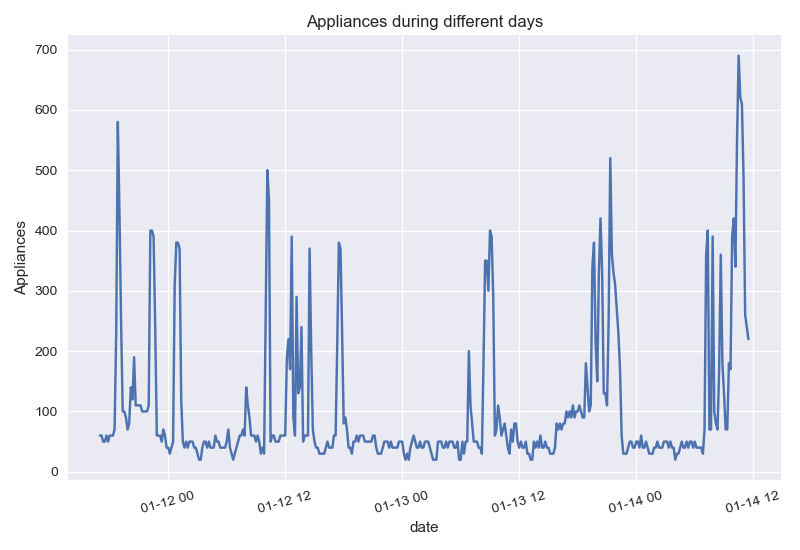

In [13]:
from datetime import datetime, timedelta
from matplotlib import pyplot as plt
from matplotlib import dates as mpl_dates

plt.style.use('seaborn')

train_data['date'] = pd.to_datetime(train_data['date'], format = '%Y-%m-%d %H:%M:%S')

plotdf = train_data[['date', 'Appliances']]
plotdf = plotdf.head(400)

sns.lineplot(x='date', y="Appliances", data=plotdf)
plt.xticks(rotation=15)
plt.title('Appliances during different days')

plt.tight_layout()

plt.show()

On the above plot, we can see that there are some trends in the data. When we reason and think about this, this is very straightforward. During the peak hours of the day, there are more appliances in use what makes the consumption rise. During the night we can also clearly see a low consumption. However, this is only for the first 400 data points, we can't make any conclusion yet. therefore I will add a new column with the average appliance consumption over the whole data frame for every hour of every day. This is already some feature engineering but this will help us plot the data better.

In [14]:
#gets all the hours of a day that occurs in the dataframes
def get_hours():
    hours = []
    dates = train_data.date
    idx = 0
    for i, date in enumerate(dates):
        if not (np.isin(date.time(), hours)):
            hours.append(date.time())
            idx = idx + 1
    return hours

hours = np.array(get_hours())

In [15]:
def Average(lst):
    return sum(lst) / len(lst)

def get_mean(hour, variable, dataset):
    
    res = [] 
    for i, x in enumerate(dataset.date): 
        if(x.time() == hour):
            res.append(dataset[variable][i])
    return Average(res)

def add_mean(hours, variable, dataset):
    means = {} 
    for hour in hours:
        mean = get_mean(hour, variable, dataset)
        means[hour] = mean
    return means

def get_meansArray(variable, hours, dataset, size):
    means = add_mean(hours, variable, dataset)
    meansArray = np.zeros(size)
    for i, date in enumerate(dataset.date):
        meansArray[i] = means[date.time()]
    return meansArray

In [16]:
def calculateAverage(column, dataset, size):
    means = get_meansArray(column, hours, dataset, size)
    df = pd.DataFrame(data=means, columns=[f'mean{column}'])
    return df

In [17]:
MeanAppliances = calculateAverage('Appliances', train_data, len(train_data))
train_data['MeanAppliances'] = MeanAppliances

In [18]:
train_data.head()

date  lights     T1       RH_1    T2       RH_2     T3  \
0 2016-01-11 17:00:00      30  19.89  47.596667  19.2  44.790000  19.79   
1 2016-01-11 17:10:00      30  19.89  46.693333  19.2  44.722500  19.79   
2 2016-01-11 17:20:00      30  19.89  46.300000  19.2  44.626667  19.79   
3 2016-01-11 17:30:00      40  19.89  46.066667  19.2  44.590000  19.79   
4 2016-01-11 17:40:00      40  19.89  46.333333  19.2  44.530000  19.79   

        RH_3         T4       RH_4  ...     T_out  Press_mm_hg  RH_out  \
0  44.730000  19.000000  45.566667  ...  6.600000        733.5    92.0   
1  44.790000  19.000000  45.992500  ...  6.483333        733.6    92.0   
2  44.933333  18.926667  45.890000  ...  6.366667        733.7    92.0   
3  45.000000  18.890000  45.723333  ...  6.250000        733.8    92.0   
4  45.000000  18.890000  45.530000  ...  6.133333        733.9    92.0   

   Windspeed  Visibility  Tdewpoint        rv1        rv2  Appliances  \
0   7.000000   63.000000        5.3  13.275433  13.275433          60   
1   6.666667   59.166667        5.2  18.606195  18.606195          60   
2   6.333333   55.333333        5.1  28.642668  28.642668          50   
3   6.000000   51.500000        5.0  45.410389  45.410389          50   
4   5.666667   47.666667        4.9  10.084097  10.084097          60   

   MeanAppliances  
0      123.047619  
1      121.333333  
2      138.380952  
3      166.476190  
4      178.285714  

[5 rows x 30 columns]

<IPython.core.display.Javascript object>


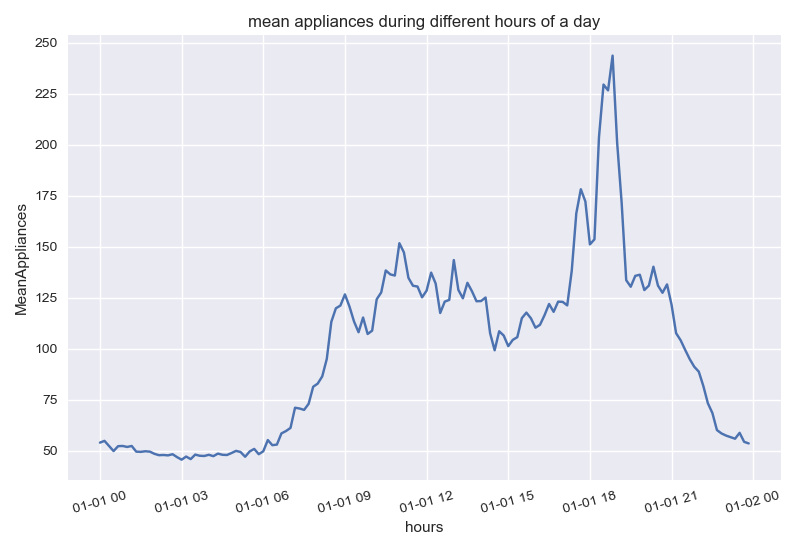

In [19]:
plotdf = train_data[['MeanAppliances']].head(len(hours))
x = pd.DataFrame(hours, columns=['hours'])
x = pd.to_datetime(x['hours'], format = '%H:%M:%S')
plotdf['hours'] = x

plotdf.head(144)

plt.figure()
sns.lineplot(x='hours', y="MeanAppliances", data=plotdf)
plt.xticks(rotation=15)
plt.title('mean appliances during different hours of a day')

plt.tight_layout()

plt.show()

Here we plot the mean appliances over every hour of our dataset. We can see that during the night the appliances are fairly low. Around 7:00 the appliances start and climb and stay somewhat stable until 17:30 and then peak around 18:30. this is probably when most of the people come home from work.

### Data distribution

Regression techniques work better on data that is Gaussian distributed. Let's see if this is the case with the data given. One way of knowing is by looking at the skewness of a plot. We will first show a histogram of all variables.

<IPython.core.display.Javascript object>


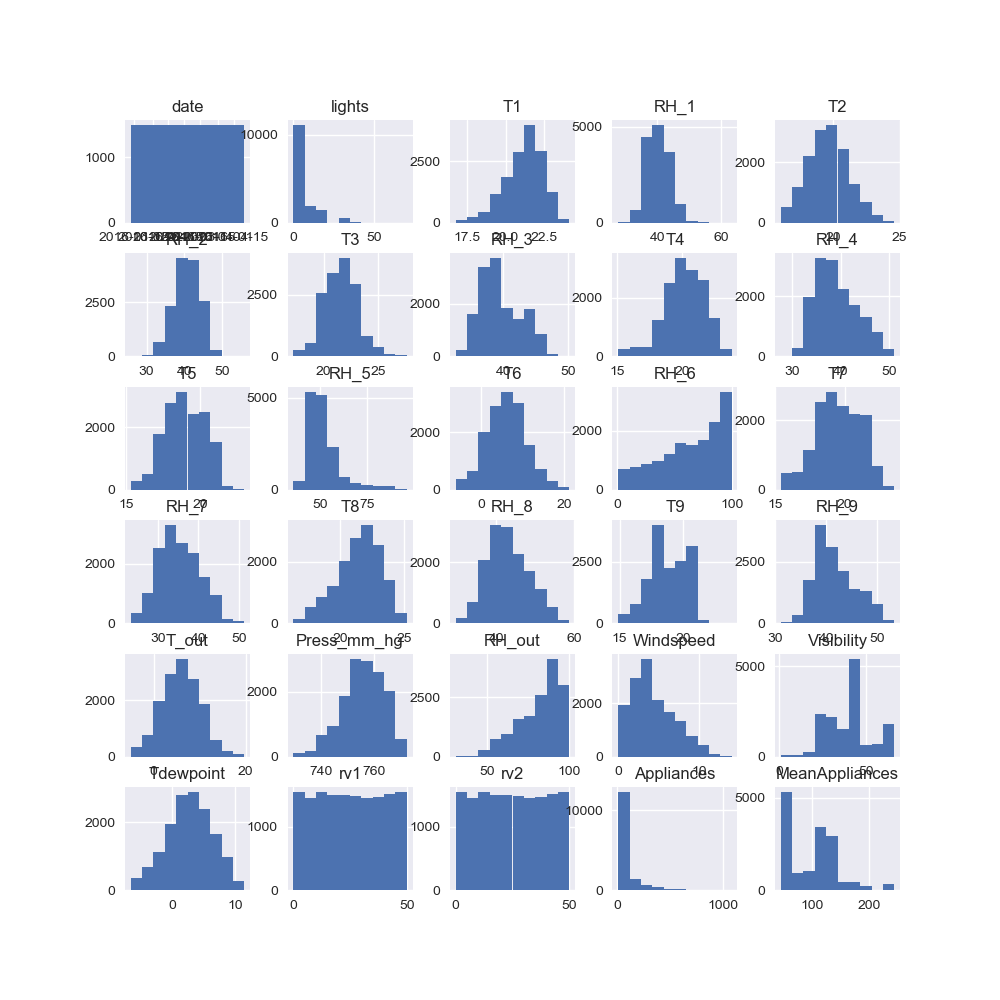

In [20]:
train_data.hist(figsize = (10,10)) # figsize: (width,height)
pass

On the above histograms, we can see that not all data is uniformly distributed. It may help the model to normalize the data at a later stage to improve performance. Let's plot the skewness of the target variable appliances.

<IPython.core.display.Javascript object>


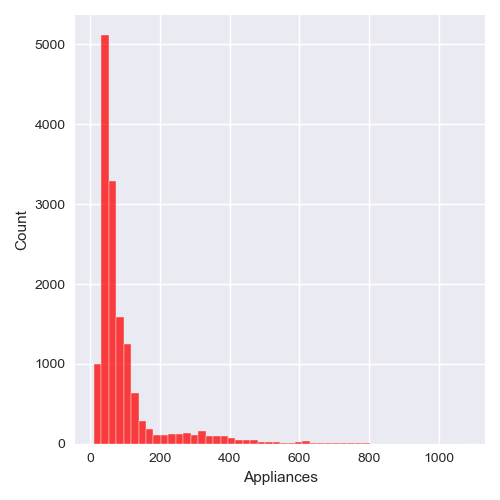

<IPython.core.display.Javascript object>


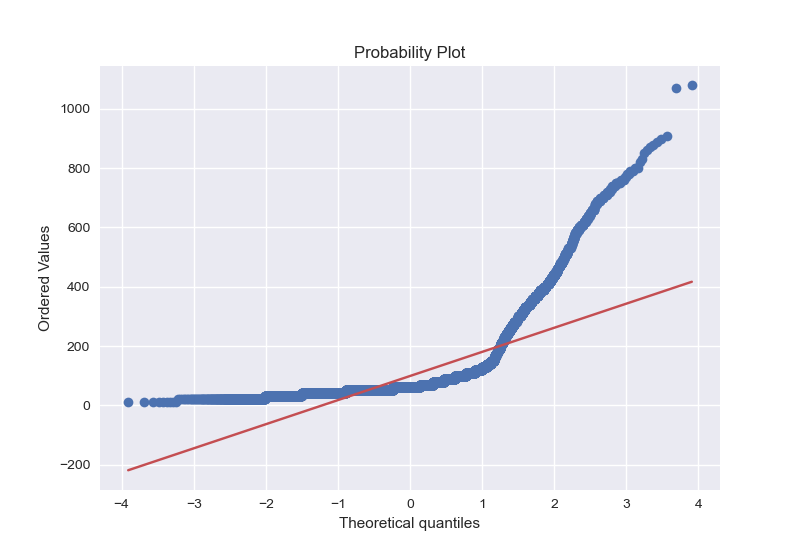

In [21]:
sns.displot(train_data['Appliances'],bins=50,color='r')
fig = plt.figure()
res = stats.probplot(train_data['Appliances'], plot=plt)

We notice that we deviate from the normal distribution and the target variable is positive skewed.

In [22]:
#skewness and kurtosis
print(f"Skewness: {train_data['Appliances'].skew()}")
print(f"Kurtosis: {train_data['Appliances'].kurt()}")

Skewness: 3.2844497903030994
Kurtosis: 12.79470992079976


We can notice a high skew and kurtosis which is not ideal fro regression problems.

## 2) Preprocessing and feature extraction

### Correlations
Lets see if there is any data correlated with the target variable.

<IPython.core.display.Javascript object>


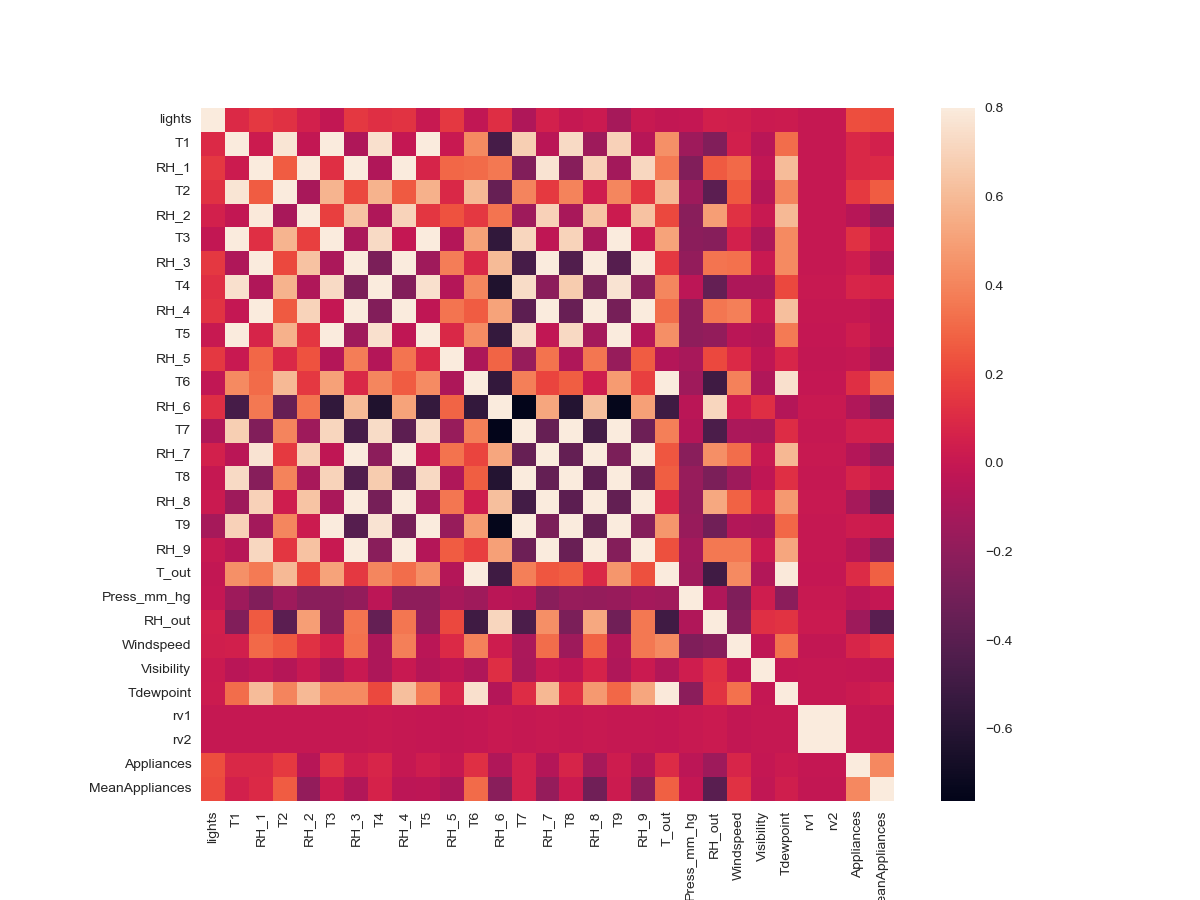

In [23]:
#correlation matrix
corrmat = train_data.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True);

On this heatmap we can not see variables with a clear correlation to our target variable. That's why we are gonna get seaborn to give us the ones with the most correlation.

<IPython.core.display.Javascript object>


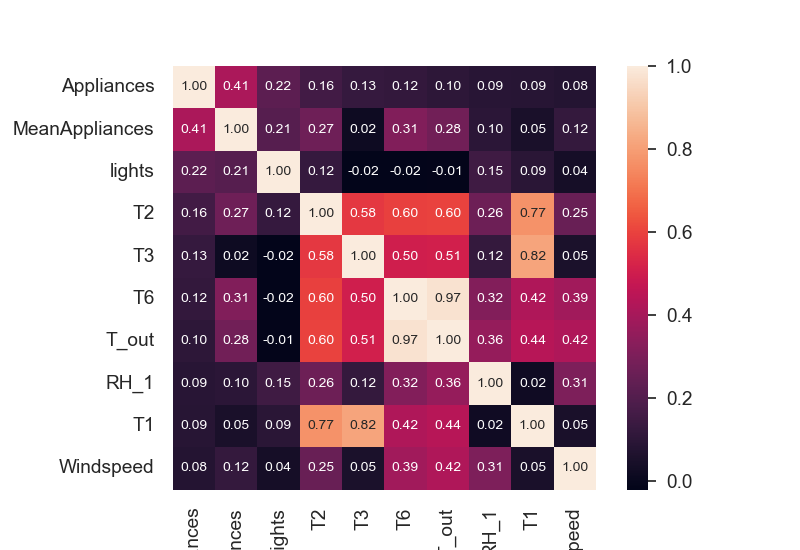

In [24]:
k = 10 #number of variables for heatmap
cols = corrmat.nlargest(k, 'Appliances')['Appliances'].index
cm = np.corrcoef(train_data[cols].values.T)
plt.figure()
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

On this more concentrated heatmap we can see more details. We can notice that some variables correlate with each other. this can introduce some multicollinearity. Which is not good for our model. This means that these variables contribute almost the same information. An example is T6 with T_out, it is obvious that the temperature measured on the outside wall of the house (T6) is almost the same as the outside temperature from the weather station. We will keep T6 as it has a greater correlation with the target variable. This is also the case for T1 with T2 and T3 we will keep T2 and T3.

<IPython.core.display.Javascript object>


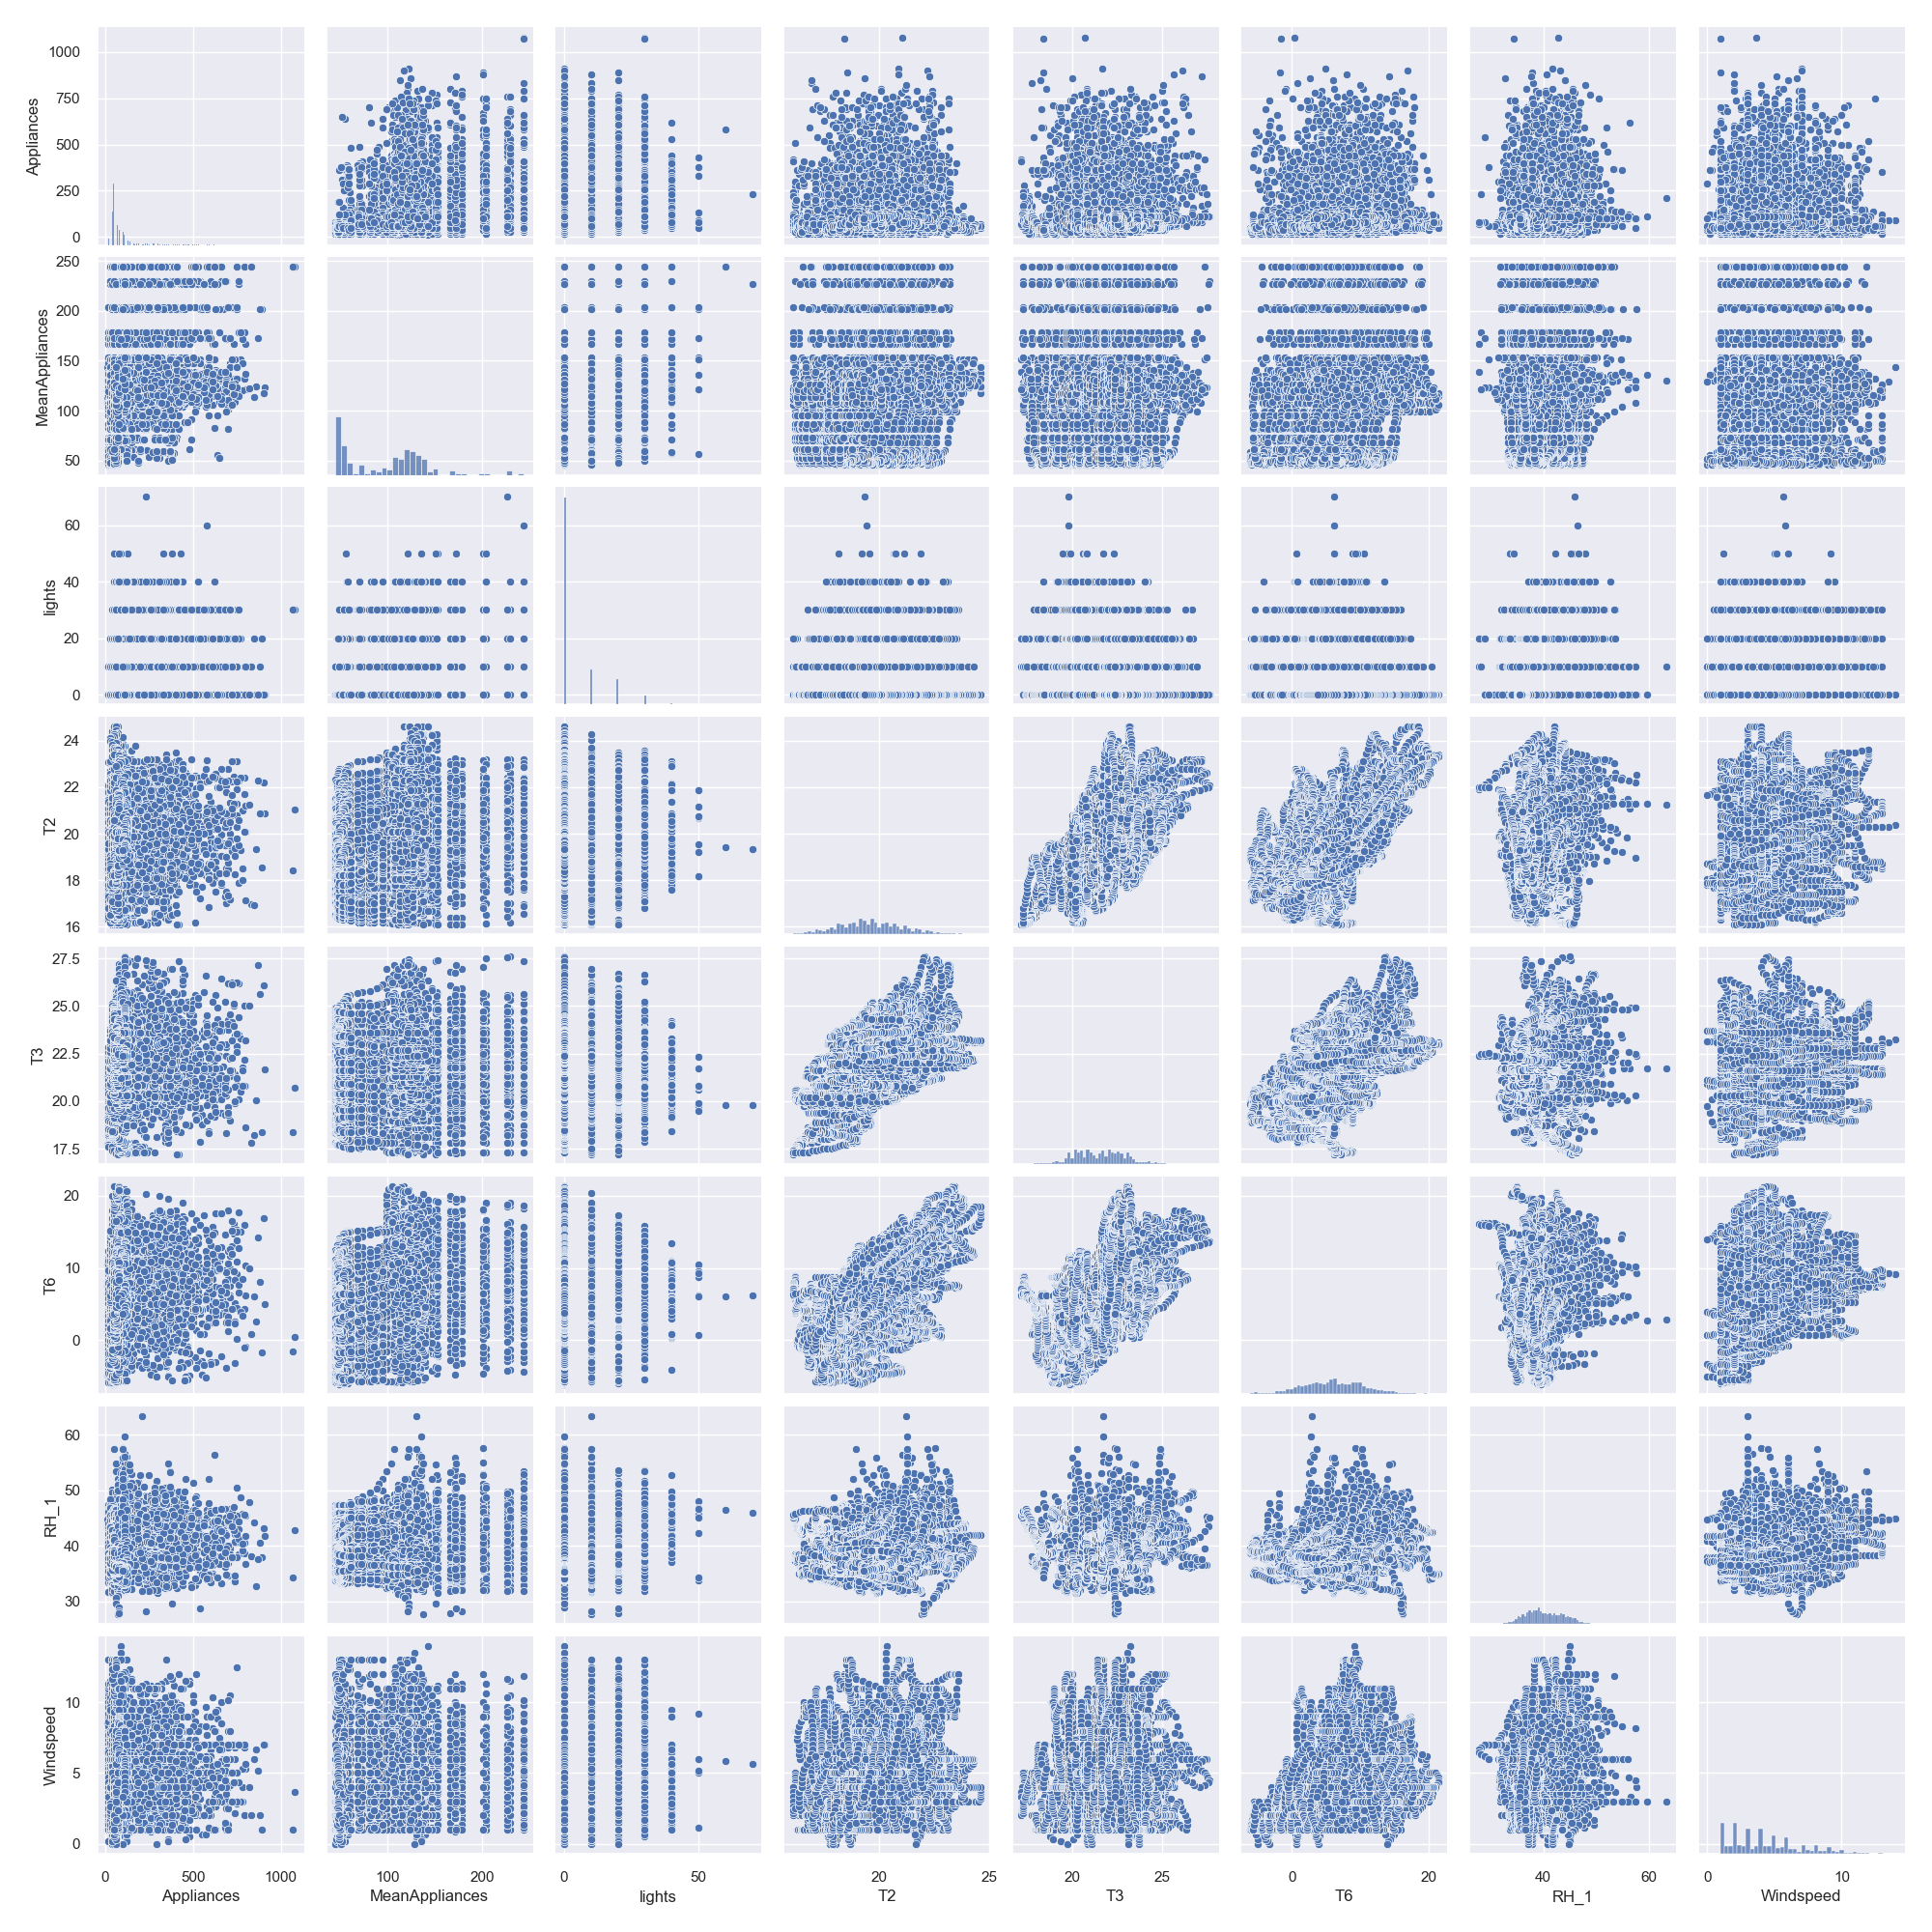

In [25]:
#scatterplot
sns.set()
cols = ['Appliances', 'MeanAppliances', 'lights', 'T2', 'T3', 'T6', 'RH_1','Windspeed']
sns.pairplot(train_data[cols], height = 2.5)
plt.show();

Looking at the above scatterplots we can get a lot of information. For example, we can see that the temperature variables have a kind of linear relationship with each other. What makes sense, however, we can't say the same about appliances and any other variable, this can be an indication to not use linear regression.

### Outliers
Another important thing to check in the data is the outliers. Outliers are bad for our regression model and can make the prediction perform less. However, we have to be careful with deleting outliers because they can also just be part of our data and not just outliers.

Here we will be normalizing the data to check for any outliers in the high and low ranges of the appliances.

In [26]:
from sklearn.preprocessing import StandardScaler
#standardizing data
appliances_scaled = StandardScaler().fit_transform(train_data['Appliances'][:,np.newaxis]);
low_range = appliances_scaled[appliances_scaled[:,0].argsort()][:15]
high_range= appliances_scaled[appliances_scaled[:,0].argsort()][-15:]
print('outer range (low) of the distribution:')
print(low_range)
print('\nouter range (high) of the distribution:')
print(high_range)

outer range (low) of the distribution:
[[-0.8339854 ]
 [-0.8339854 ]
 [-0.8339854 ]
 [-0.8339854 ]
 [-0.8339854 ]
 [-0.8339854 ]
 [-0.8339854 ]
 [-0.8339854 ]
 [-0.8339854 ]
 [-0.74001663]
 [-0.74001663]
 [-0.74001663]
 [-0.74001663]
 [-0.74001663]
 [-0.74001663]]

outer range (high) of the distribution:
[[6.49557901]
 [6.58954778]
 [6.58954778]
 [6.58954778]
 [6.77748533]
 [6.87145411]
 [7.05939166]
 [7.15336043]
 [7.24732921]
 [7.34129798]
 [7.43526675]
 [7.52923553]
 [7.6232043 ]
 [9.1267047 ]
 [9.22067347]]


C:\Users\alexc\AppData\Local\Temp/ipykernel_1584/1260172062.py:3: FutureWarning:

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.



Here we can see that in the high ranges we could have some outliers but we will not remove them (yet). However, when looking at the boxplot given below and at the scatterplots above we can see that two points behave weirdly, therefore I decided to drop these two values, which will probably also eliminate the 9's from the outer range.

<IPython.core.display.Javascript object>


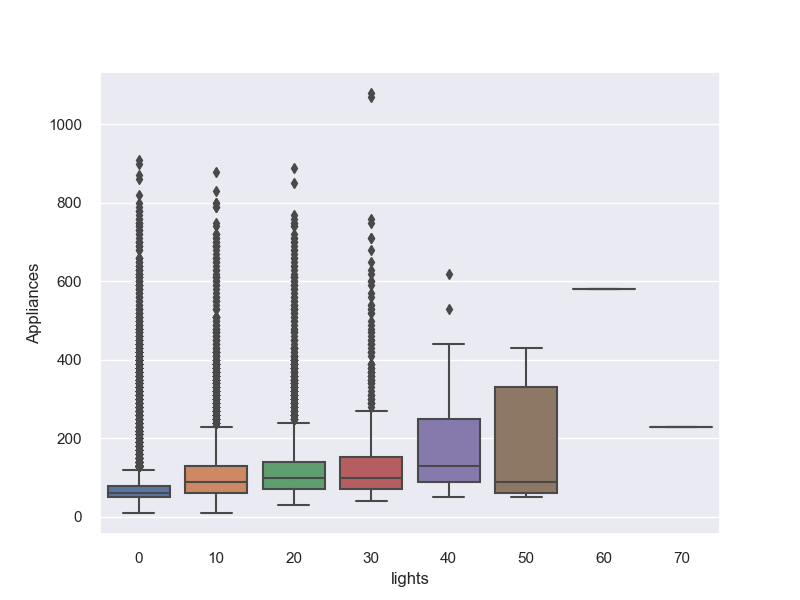

In [27]:
var = 'lights'
data = pd.concat([train_data['Appliances'], train_data[var]], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x=var, y="Appliances", data=data)

In [28]:
idx1 = train_data[(train_data['Appliances'] > 1000)].index.tolist()
idx2 = train_data[(train_data['lights'] > 55)].index.tolist()

train_data = train_data.drop(idx1)
train_data = train_data.drop(idx2)


## Feature Engineering
Now that we have an insight into the data we can do some feature engineering. First, we will extract the date variable into more meaningful variables and add a variable that tells us if we are in a weekend yes or no.

In [29]:
# assign your new columns
datetimes = train_data['date']
train_data['year'] = datetimes.dt.year
train_data['month'] = datetimes.dt.month
train_data['day'] = datetimes.dt.day
train_data['day_of_week'] = datetimes.dt.dayofweek
train_data['is_weekend'] = np.where(train_data['day_of_week'].isin([5, 6]), 1.0,0.0)
train_data['hour'] = datetimes.dt.hour
#df['is_peak'] = np.where(df['hour'].isin([8,9,12,19,22]), 1,0)
train_data['minute'] = datetimes.dt.minute
train_data = train_data.drop(['date'], axis=1)
pass

We can also do the same engineering just like the meanAppliances.
When we have a look into the data we see that we have different temperatures for different rooms.
One of those rooms is the ironing room. However, we can maybe see a correlation between the use of the ironing room (hotter when using the iron) and a "peak" in appliances.
We will add an extra variable to the dataset with the difference between the living room and the ironing room, when this difference is significant we can assume that the ironing room is being used and that there are more appliances in use.

In [30]:
ironingRoomTemp = train_data.T7
livingRoomTemp = train_data.T2

ironing = livingRoomTemp.subtract(ironingRoomTemp)

for i, x in enumerate(ironing):
    if(x > 1):
        ironing[i] = 1
    else:
        ironing[i] = 0
train_data['ironing'] = ironing


Another observation we can make is the fact that there is a laundry room. Maybe the temperature or the humidity in the laundry room is a bit higher than usual. we can do the same thing for laundry temperature as above.

In [31]:
laundryRoomTemp = train_data.T3

laundry = livingRoomTemp.subtract(laundryRoomTemp)

for i, x in enumerate(laundry):
    if(x > 1):
        laundry[i] = 1
    else:
        laundry[i] = 0
train_data['laundry'] = laundry

In [32]:
train_data.head()

lights     T1       RH_1    T2       RH_2     T3       RH_3         T4  \
0      30  19.89  47.596667  19.2  44.790000  19.79  44.730000  19.000000   
1      30  19.89  46.693333  19.2  44.722500  19.79  44.790000  19.000000   
2      30  19.89  46.300000  19.2  44.626667  19.79  44.933333  18.926667   
3      40  19.89  46.066667  19.2  44.590000  19.79  45.000000  18.890000   
4      40  19.89  46.333333  19.2  44.530000  19.79  45.000000  18.890000   

        RH_4         T5  ...  MeanAppliances  year  month  day  day_of_week  \
0  45.566667  17.166667  ...      123.047619  2016      1   11            0   
1  45.992500  17.166667  ...      121.333333  2016      1   11            0   
2  45.890000  17.166667  ...      138.380952  2016      1   11            0   
3  45.723333  17.166667  ...      166.476190  2016      1   11            0   
4  45.530000  17.200000  ...      178.285714  2016      1   11            0   

   is_weekend  hour  minute  ironing  laundry  
0         0.0    17       0      1.0      0.0  
1         0.0    17      10      1.0      0.0  
2         0.0    17      20      1.0      0.0  
3         0.0    17      30      1.0      0.0  
4         0.0    17      40      1.0      0.0  

[5 rows x 38 columns]

Since we have added some new variables we can search for the variables with the most correlations again, we already have our variables from the previous analysis holding it in the "cols" variable. these were: ['Appliances', 'MeanAppliances', 'lights', 'T2', 'T3', 'T6', 'RH_1', 'Windspeed']. we already decided to leave T_out and T1 out of the data.

<IPython.core.display.Javascript object>


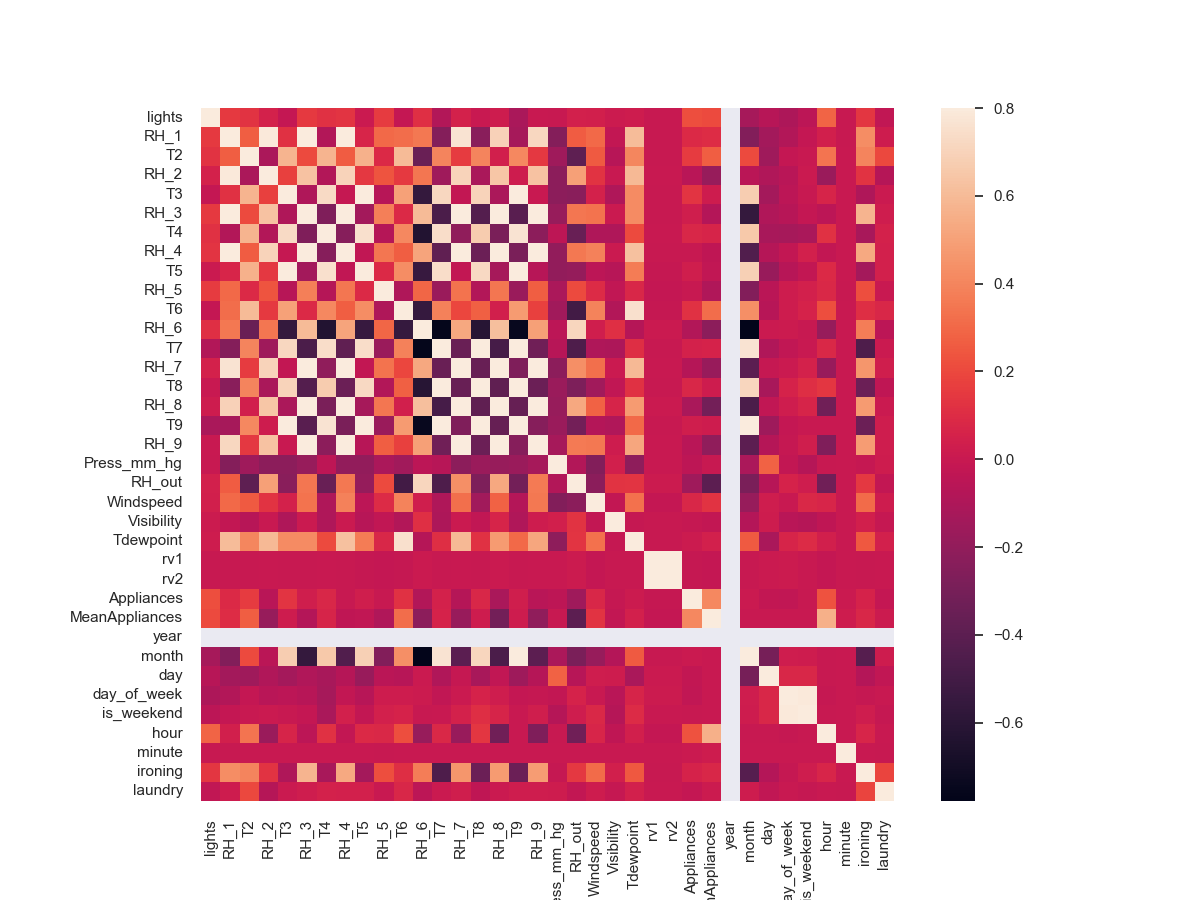

In [33]:
#drop columns T_out and T1
train_data = train_data.drop(['T1', 'T_out'], axis=1)

#correlation matrix
corrmat = train_data.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True);

<IPython.core.display.Javascript object>


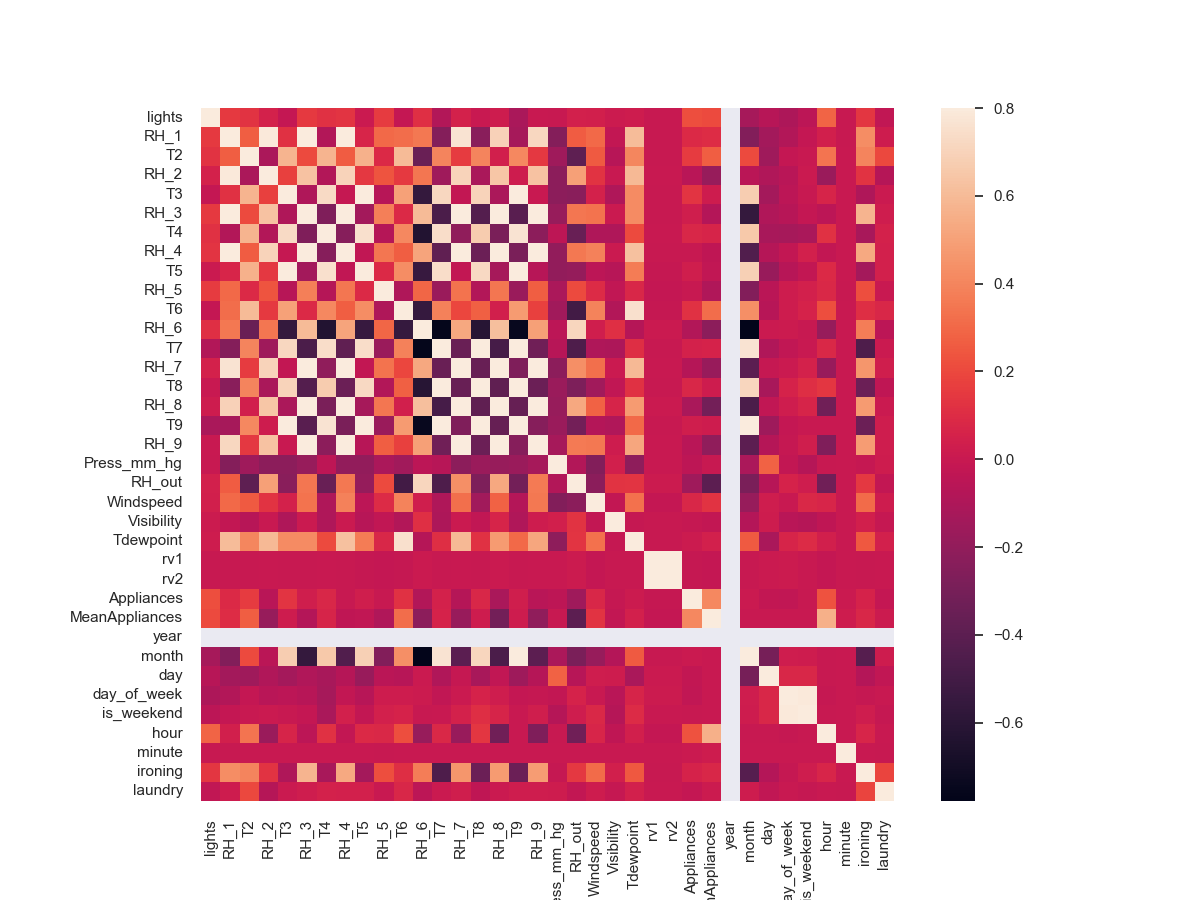

<IPython.core.display.Javascript object>


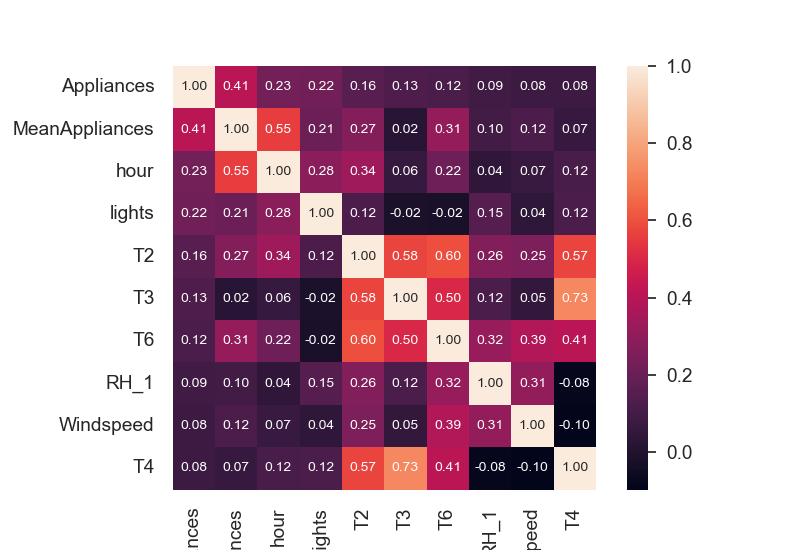

In [34]:
#correlation matrix
corrmat = train_data.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True);

k = 10 #number of variables for heatmap
cols = corrmat.nlargest(k, 'Appliances')['Appliances'].index
cm = np.corrcoef(train_data[cols].values.T)
plt.figure()
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

Here we can see that there are new more correlated variables, we can add these to our cols cariable to use in our model.

### Feature Selection
Feature selection plays an important role in training your model. However, I did not manage to make my model by using any feature selection. I have tried multiple things, the future selection of sklearn SelectKbest, I have tried selecting manually by looking at the correlation matrix and selecting the ones with the most correlation. Finally, I have also tried using the recursive feature selection from Sklearn, here I got the "best" selection, but it still has not surpassed the RMSE with all the features.

This feature selection has been done by a RFE in the code below.

## 3) Training/validation/test split strategy
Now we can start training our model. Here we will split our training data using the train_test_split function from sklearn. We put shuffle to false since we have ordered data and we don't want to shuffle them and mess up our predictions. 

In [35]:
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.model_selection import TimeSeriesSplit
from sklearn.feature_selection import SelectKBest, f_classif

Target = train_data.Appliances
X = train_data.drop('Appliances', axis=1)

tscv = TimeSeriesSplit(n_splits=5)

#PCA did not improve
# pca = PCA(n_components=5)
# X = pca.fit(X).transform(X)

In [36]:
from sklearn.linear_model import BayesianRidge
import xgboost as xgb
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn import metrics

bayes = BayesianRidge()
Xgb = XGBRegressor( n_jobs = -1)
Lgb = LGBMRegressor(n_jobs = -1)

In [37]:
from pandas import read_csv
from sklearn.feature_selection import RFE, RFECV
from sklearn.ensemble import RandomForestRegressor
from matplotlib import pyplot
# load dataset

# perform feature selection
rfe = RFE(Xgb, n_features_to_select=5)
fit = rfe.fit(X, Target)
# report selected features
names = X.columns.values
columns = []
print('Selected Features:')
for i in range(len(fit.support_)):
    if fit.support_[i]:
        columns.append(names[i])
print(columns)

Selected Features:
['lights', 'MeanAppliances', 'month', 'day_of_week', 'hour']


In [38]:
X = X[columns]

tscv = TimeSeriesSplit(n_splits=6)
test_fraction = 0.25
X_train, X_test, y_train, y_test = train_test_split(X, Target, test_size = test_fraction, shuffle = False)

In [39]:
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import PowerTransformer, RobustScaler, StandardScaler, MinMaxScaler
from sklearn.model_selection import cross_val_score

## 4) Model training and hyperparameter tuning

We can start to train our models, but first, we will find some hyperparameters for our different models using gridsearchCV. Sometimes it is useful to first run the base model to be able to compare the difference with hyperparameter tuning and without. But generally Hyperparameter tuning results in better predictions therefore I decided to omit the results from the base models.

In [40]:
#function to perform grid search on a given model and given parameter list
def grid_search_cv(model, params):
    global best_params, best_score
    from sklearn.model_selection import GridSearchCV
    grid_search = GridSearchCV(estimator = model, param_grid = params, cv = tscv, verbose = 5,
                            scoring = 'neg_root_mean_squared_error', n_jobs = -1,error_score='raise')
    grid_search.fit(X_train, y_train)
    best_params = grid_search.best_params_ 
    best_score = np.sqrt(-1*(np.round(grid_search.best_score_, 5)))
    return best_params, best_score


In [41]:
#Parameter grid for XGBoost
param_grid={"eta": (0.05, 0.10, 0.2, 0.3),
            "max_depth": [ 3, 4, 5, 6, 8],
            "min_child_weight": [ 1, 3, 5, 7],
            "gamma":[ 0.0, 0.1, 0.2, 0.3],
            'n_estimators': [24, 50 ,150, 300],
            "colsample_bytree":[ 0.3, 0.5, 0.8, 1],}

#Xgb_grid_result = grid_search_cv(Xgb, param_grid)
#print(Xgb_grid_result)

In [42]:
#Xgb_params = Xgb_grid_result[0]
Xgb_params = {'colsample_bytree': 1, 'eta': 0.05, 'gamma': 0.0, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 50}
Xgb_opt = XGBRegressor(**Xgb_params, n_jobs = -1)

In [43]:
#Parameter grid for LGBoost
param_grid={'learning_rate': (0.01,  0.05, 0.1, 0.15, 0.2),
            'num_leaves': (10, 24, 36, 80),
            'n_estimators': [24, 50 ,150, 300],
            'max_depth': (3,4,5,6,8),
            'max_bin':(20, 40, 90),
            'min_data_in_leaf': (5, 10, 20),
            'subsample': (0.01, 0.05, 0.1, 0.2)}

##Lgb_grid_result = grid_search_cv(Lgb, param_grid)
#print(Lgb_grid_result)

In [44]:
#Lgb_params = Lgb_grid_result[0]
Lgb_params = {'learning_rate': 0.05, 'max_bin': 40, 'max_depth': 6, 'min_data_in_leaf': 5, 'n_estimators': 24, 'num_leaves': 10, 'subsample': 0.01}
Lgb_opt = LGBMRegressor(**Lgb_params, n_jobs = -1)

In [45]:
#Parameter grid for Bayesian ridge
param_grid={'alpha_init': (0.01, 0.10, 0.5, 1.0, 2.0, 5.0, 10.0, 20.0, 50.0),
            'alpha_1': (0.01, 0.10, 0.5, 1.0, 2.0, 5.0, 10.0, 20.0, 50.0),
            'lambda_init': (0.01, 0.10, 0.5, 1.0, 2.0, 5.0, 10.0, 20.0, 50.0),
            'lambda_1': (0.01, 0.10, 0.5, 1.0, 2.0, 5.0, 10.0, 20.0, 50.0)}
#Bayes_grid_result = grid_search_cv(bayes, param_grid)
#print(Bayes_grid_result)

In [46]:
#Bayes_params = Bayes_grid_result[0]
Bayes_params = {'alpha_1': 50.0, 'alpha_init': 0.01, 'lambda_1': 5.0, 'lambda_init': 0.1}
Bayes_opt = BayesianRidge(**Bayes_params)

Creating different pipelines where we will first scale the data using a scaler of sklearn

In [47]:
Xgb_pipe = make_pipeline(MinMaxScaler(feature_range=(-1,1)),Xgb_opt)
Lgb_pipe = make_pipeline(MinMaxScaler(feature_range=(-1,1)),Lgb_opt)
Bayesian_pipe = make_pipeline(MinMaxScaler(feature_range=(-1,1)),Bayes_opt)

We will perform cross-validation, using a timeseriessplit because we have time-series data. When the cross-validation has been finished we return the average score of the model with the standard deviation.

In [48]:
from sklearn.model_selection import cross_val_score
Xgb_scores = cross_val_score(Xgb_pipe, X_train, y_train, cv=tscv, scoring = 'neg_root_mean_squared_error', n_jobs = -1)
Lgb_scores = cross_val_score(Lgb_pipe, X_train, y_train, cv=tscv, scoring = 'neg_root_mean_squared_error', n_jobs = -1)
bayesian_scores = cross_val_score(Bayesian_pipe, X_train, y_train, cv=tscv, scoring = 'neg_root_mean_squared_error', n_jobs = -1)

print(Xgb_scores)
print("Average validation accuracy for Xgb: ",abs(Xgb_scores.mean()),", stdev: ",Xgb_scores.std() , '\n')
print(Lgb_scores)
print("Average validation accuracy for Lgb: ",abs(Lgb_scores.mean()),", stdev: ",Lgb_scores.std() , '\n')
print(bayesian_scores)
print('Average validation accuracy for Bayes: ',abs(bayesian_scores.mean()),", stdev: ",bayesian_scores.std() , '\n')

[-98.00614673 -94.36960889 -80.07325141 -96.38773897 -92.85245136
 -91.50081063]
Average validation accuracy for Xgb:  92.19833466560185 , stdev:  5.829926723440354 

[-100.79992153  -93.30898175  -80.22951806  -98.12703599  -93.35881997
  -92.42509977]
Average validation accuracy for Lgb:  93.04156284437353 , stdev:  6.4647099679717 

[-101.09279359  -94.8084276   -84.42619474  -98.17021072  -95.48018398
  -90.01640962]
Average validation accuracy for Bayes:  93.99903670941609 , stdev:  5.4477764887902485 



In [49]:
from sklearn import metrics
Xgb_pipe.fit(X_train, y_train)
XgbPred = Xgb_pipe.predict(X_test)

Xgb_train_score = Xgb_pipe.score(X_train, y_train)
Xgb_test_score = Xgb_pipe.score(X_test, y_test)

print("Accuracy of Xgradient_boost model: ",Xgb_train_score," (train), ",Xgb_test_score," (test)")
print('Root Mean Squared Error of Lgradient_boost on training/validation set:', np.sqrt(metrics.mean_squared_error(y_test, XgbPred)))

Accuracy of Xgradient_boost model:  0.2477381566125405  (train),  0.13471387642428034  (test)
Root Mean Squared Error of Lgradient_boost on training/validation set: 94.98084732719592


In [50]:
from sklearn import metrics
Lgb_pipe.fit(X_train, y_train)
LgbPred = Lgb_pipe.predict(X_test)

Lgb_train_score = Lgb_pipe.score(X_train, y_train)
Lgb_test_score = Lgb_pipe.score(X_test, y_test)

print("Accuracy of Lgradient_boost model: ",Lgb_train_score," (train), ",Lgb_test_score," (test)")
print('Root Mean Squared Error of Lgradient_boost on training/validation set:', np.sqrt(metrics.mean_squared_error(y_test, LgbPred)))

[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
Accuracy of Lgradient_boost model:  0.23319286706399311  (train),  0.13516894102786425  (test)
Root Mean Squared Error of Lgradient_boost on training/validation set: 94.95586824527453


In [51]:
predictions = LgbPred

<IPython.core.display.Javascript object>


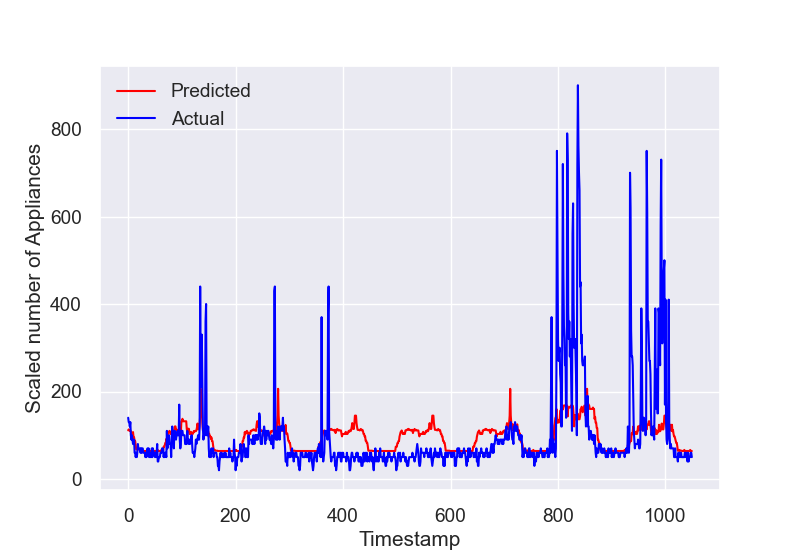

In [52]:
# Showing the predicted vs. actual values
fig, axs = plt.subplots()

axs.plot(predictions[:1050],color='red', label='Predicted')
axs.plot(y_test.values[:1050],color='blue', label='Actual')
plt.xlabel('Timestamp')
plt.ylabel('Scaled number of Appliances')
plt.legend(loc='upper left')
plt.show()

### create a submission

How to create a submission. (not my best)

In [53]:
# meansArray = np.zeros(4735)
# ironingRoomTemp = test_data.T7
# livingRoomTemp = test_data.T2

# duplicate_train['date'] = pd.to_datetime(duplicate_train['date'], format = '%Y-%m-%d %H:%M:%S')
# test_data['date'] = pd.to_datetime(test_data['date'], format = '%Y-%m-%d %H:%M:%S')
# for i, date in enumerate(test_data.date):
#     meansArray[i] = get_mean(date.time(), 'Appliances', duplicate_train)

# test_data['MeanAppliances'] = meansArray

In [54]:
# # assign your new columns
# datetimes = test_data['date']
# test_data['year'] = datetimes.dt.year
# test_data['month'] = datetimes.dt.month
# test_data['day'] = datetimes.dt.day
# test_data['day_of_week'] = datetimes.dt.dayofweek
# test_data['is_weekend'] = np.where(test_data['day_of_week'].isin([5, 6]), 1.0,0.0)
# test_data['hour'] = datetimes.dt.hour
# #df['is_peak'] = np.where(df['hour'].isin([8,9,12,19,22]), 1,0)
# test_data['minute'] = datetimes.dt.minute
# test_data = test_data.drop(['date', 'T1', 'T_out'], axis=1)
# pass

In [55]:
# ironingRoomTemp = test_data.T7
# livingRoomTemp = test_data.T2

# ironing = livingRoomTemp.subtract(ironingRoomTemp)

# for i, x in enumerate(ironing):
#     if(x > 1):
#         ironing[i] = 1
#     else:
#         ironing[i] = 0
# test_data['ironing'] = ironing


# laundryRoomTemp = test_data.T3

# laundry = livingRoomTemp.subtract(laundryRoomTemp)

# for i, x in enumerate(laundry):
#     if(x > 1):
#         laundry[i] = 1
#     else:
#         laundry[i] = 0
# test_data['laundry'] = laundry


In [56]:
# xcols = ['lights', 'MeanAppliances', 'month', 'day_of_week', 'hour']
# test_data = test_data[xcols]
# pred = Lgb_pipe.predict(test_data)
# predictions = np.full(test_data.shape[0], pred)
# len(predictions)

In [57]:
# def generate_unique_filename(basename, file_ext):
#     """Adds a timestamp to filenames for easier tracking of submissions, models, etc."""
#     timestamp = time.strftime("%Y%m%d-%H%M%S", time.localtime())
#     return basename + '_' + timestamp + '.' + file_ext

In [58]:
# submission = pd.DataFrame(data=predictions, columns=["Appliances"])
# submission.index.name = "Id"
# submission.head()

In [59]:
# submission.to_csv(generate_unique_filename("average_submission", "csv"))